# Лабораторная работа №2: Практическое применение дискретного преобразования Фурье c использованием библиотек Python для анализа речевых сигналов.

Выполнила студентка группы 9383 Лихашва Анастасия.

## Цель работы:

Практическое применение дискретного преобразования Фурье c использованием библиотек Python для анализа речевых сигналов.

## Задачи лабораторной работы:

1. Используя ДПФ построить траекторию основного тона (F0) на записи своего голоса.
2. Используя ДПФ построить траектории второй, третьей и четвертой формантных частот на записи своего голоса
3. Построить сонограмму по записи своего голоса.

In [20]:
import wave
#открываем файл с сигналом
sound = wave.open('C:/Users/Tummix/OneDrive/Рабочий стол/мат пакеты/Лабораторная 2/lab2.wav', 'r')

/opt/sagemath-9.2/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  """
/opt/sagemath-9.2/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  """


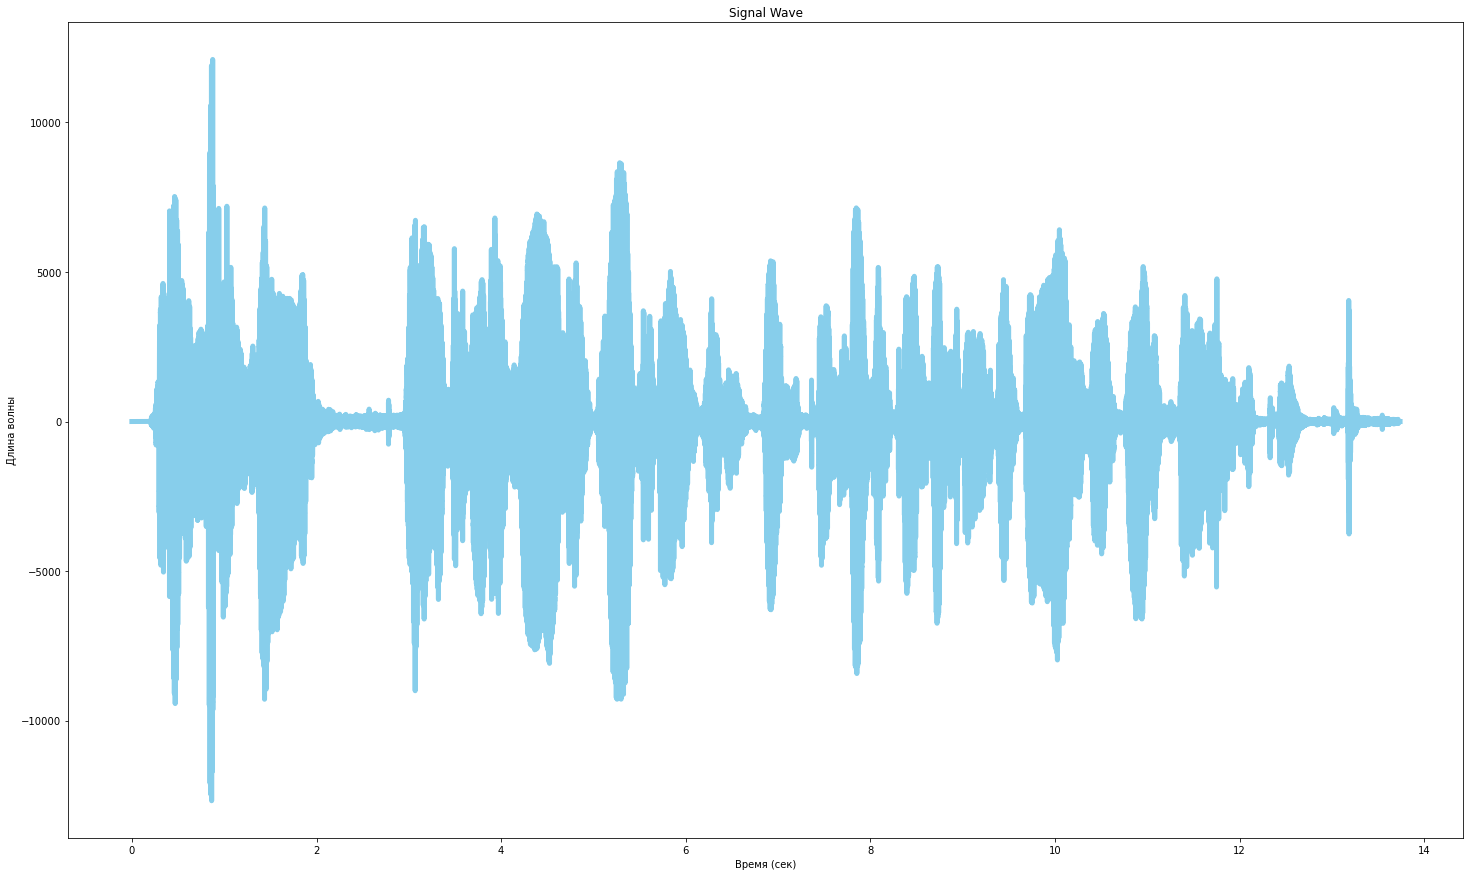

In [21]:
import matplotlib.pyplot as plt
import numpy as np

signal = sound.readframes(-1)
signal = np.fromstring(signal, 'Int16')
fd = sound.getframerate()
time = np.linspace(0, len(signal)/fd, num = len(signal))

plt.rcParams["figure.figsize"] = 25, 15  
plt.title('Signal Wave')
plt.plot(time, signal, linewidth = 5, color = 'skyblue')
plt.xlabel("Время (сек)")
plt.ylabel("Длина волны")
plt.show()

### Частота основного тона и форманты

#### Основной тон

Частотой основного тона (F0) называют частоту вибрации голосовых связок. У каждого говорящего базовая частота основного тона индивидуальна и обусловлена особенностямистроения гортани. Частота основного тона различна для мужских (примерный диапазон: 80− 200 Hz) и женских (примерный диапазон: 160− 350 Hz) голосов.

#### Форманты

Акустические резонансы в голосовом тракте создают пики в огибающей спектра звука. Такие
пики называются формантами. Частота основного тона является первой формантой, далее
идут вторая, третья и четвертая форматны: F1, F2, F3. Амплитуда каждой последующей
форманты ниже, чем предыдущей, а их частоты примерно равны частоте основного тона
умноженного на целое число:
F1 ≈ 2F0, F2 ≈ 3F0, F3 ≈ 4F0.

### Построение F0,F1,F2,F3. Начальные данные

1. Пусть частота дискретизации сигнала — $F_{d}$ $H_{z}$.
2. Выберем $N$ — размерность ДПФ (для использования быстрого алгоритма FFT $N = 2^n$ — степень двойки). Рекомендованные значения 1024, 2048 или 4096. Для перевода частоты $f_{i}$ в отсчет амплитудного спектра $n_{i}$ используем формулу: $n_{i} = \begin{bmatrix} \frac{f_{i}}{S_{r}} \end{bmatrix}$, где $S_{r} = \begin{bmatrix} \frac{F_{d}}{N} \end{bmatrix}$ − текущее спектральное разрешение.
3. Пусть диапозон основного тона для нашего голоса $[f_{l},f_{u}]$ или в отсчетах спектра $[n_{l}, n_{u}]$, где, согласно (1):  $n_{l} = \begin{bmatrix} \frac{f_{l}}{S_{r}} \end{bmatrix}$,  $n_{u} = \begin{bmatrix} \frac{f_{u}}{S_{r}} \end{bmatrix}$

### Алгоритм построения F0,F1,F2,F3

1. Разбиваем сигнал на отрезки длиной N . Рекомендуется работа с перекрытиями: сдвиг для следующего интервала 0.5N, 0.25N.
2. На каждом отрезке сигнал предварительно умножаем на окно (Хеннига (Ханна), Хемминга, Блекмана-Харриса, Кайзера-Бесселя и т.п., затем вычисляем ДПФ и на его основе амплитудный спектр в интервале (0,N/2).
3. Ищем существенное максимальное значение амплитудного спектра на отрезке $[n_{l},n_{u}]$ — это будет частота основного тона F0 (точка амплитудного спектра $n_{0}$). Если такого максимума нет — это интервал паузы или не вокализованного звука. Полагаем F0 = 0.
4. В окрестности точки $2n_{0}$ ищем максимальное значение амплитудного спектра, которое должно быть существенно меньше значения в точке $n_{0}$. Если это предположение верно, то мы нашли частоту второй форманты F1. Если нет — второй форманты у сигнала на этом отрезке нет. Полагаем F1 = 0
5. Далее проводим поиск для третьей форманты в окрестности точки $3n_{0}$. Повторяем процесс для четвертой форманты в окрестности точки $4n_{0}$.

## Построение траектории основного тона (F0) на записи своего голоса, используя ДПФ.

659456


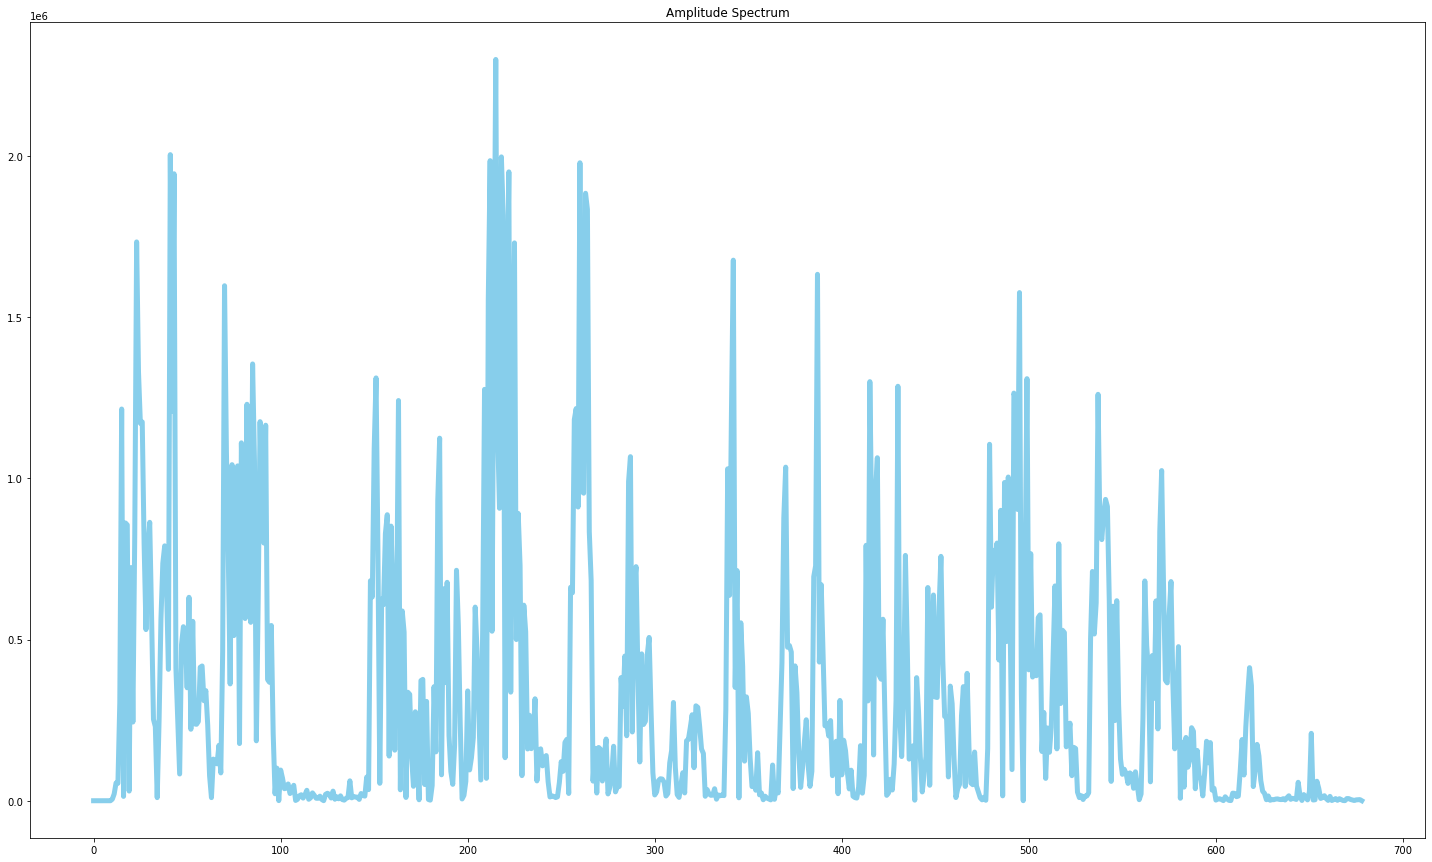

In [23]:
from scipy import hamming

N = 1024
Sr = round(fd/N)
overlap = 0.1024/2
print(len(signal))
intervals = [signal[i:i + N] for i in range(0, len(signal), N - int(overlap * N))]
intervals = [i * np.hamming(len(i)) for i in intervals]

def DFT(x):
    x = np.asarray(x, dtype = float)
    N = x.shape[0]
    n = np.arange(N)
    k = n.reshape((N, 1))
    M = np.exp(-2j * np.pi * k * n / N)
    return np.dot(M, x)

intervals = [DFT(i) for i in intervals]
amplitude_spectrum = [sum([k**2 for k in i[:int(len(i)/2)]])**0.5 for i in intervals]
amplitude_spectrum = np.array([i.real for i in amplitude_spectrum])

plt.title('Amplitude Spectrum')
plt.plot(amplitude_spectrum, linewidth = 5, color = 'skyblue')

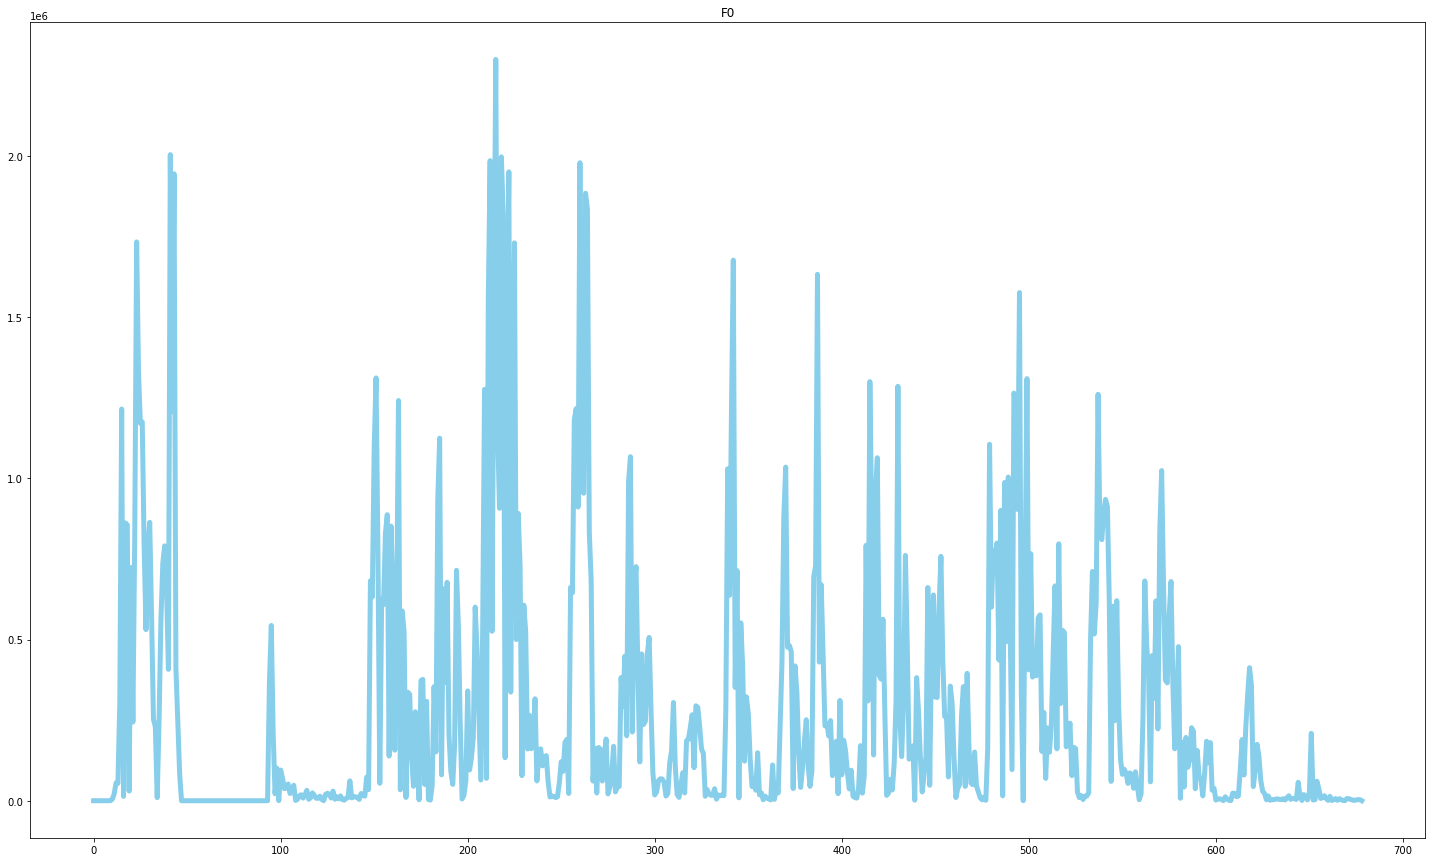

In [30]:
F0 = []

for i in [amplitude_spectrum[segment:segment + Sr] for segment in range(len(amplitude_spectrum))[::Sr]]:        
    segment = np.array(i)
    if segment.max() > 3 * segment.mean():            
        F0 += segment.tolist()
    else:
        F0 += [0 for i in range(len(segment))]       
        
plt.title('F0')        
plt.plot(F0, linewidth = 5, color = 'skyblue')       

## Построение траектории второй, третьей и четвертой формантных частот на записи своего голоса, используя ДПФ 

### F1:

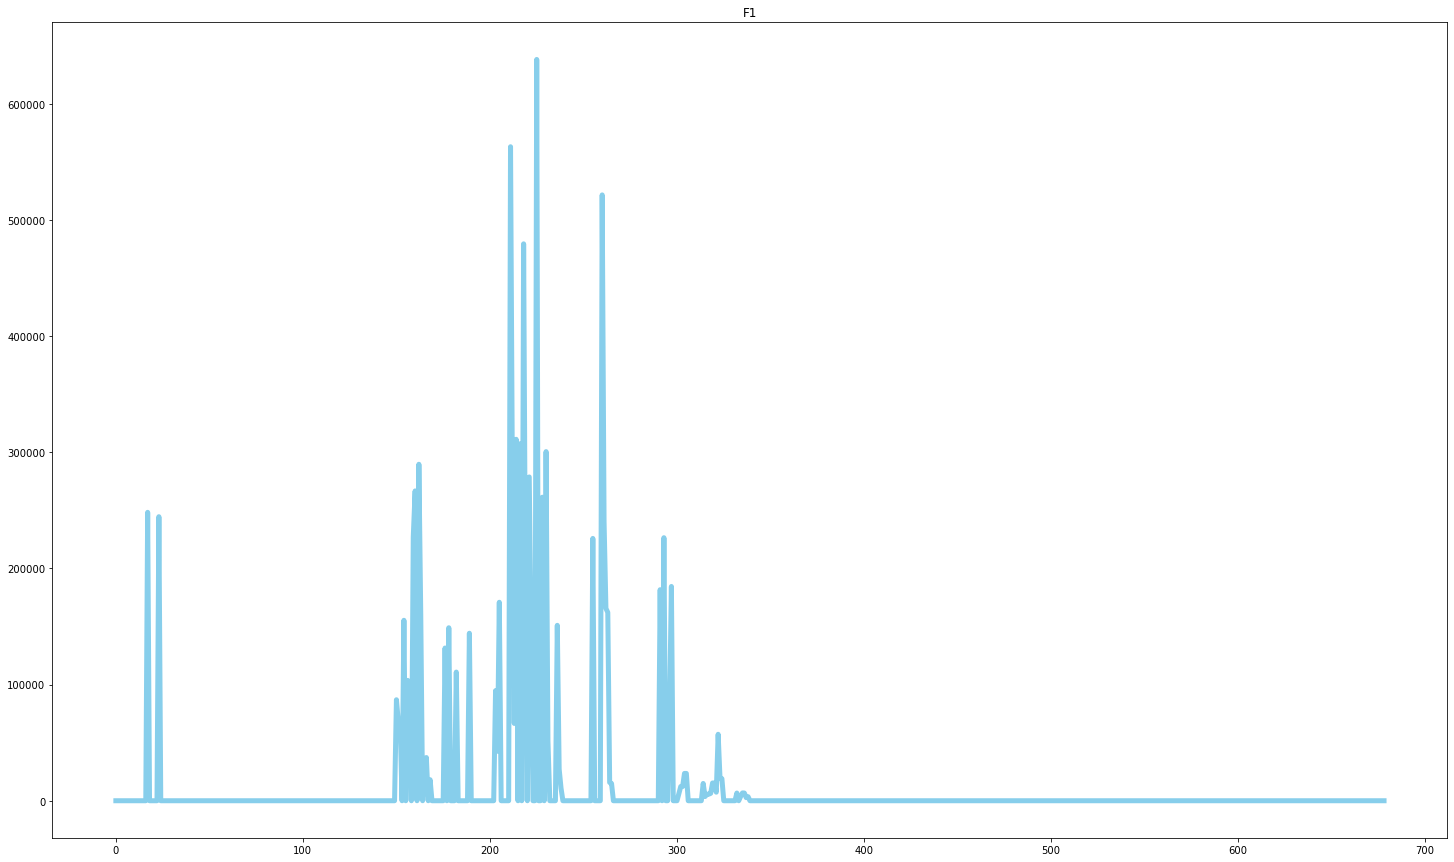

In [33]:
F1 = []
i = 0
n = len(F0)
while i < n:
    try:
        interval_max = max([F0[2 * i], F0[2 * i - 1], F0[2 * i + 1]])
        if F0[i] < 2 * interval_max: 
            F1 += [0]
        else:
            F1 += [interval_max]
    except:
        F1 += [0]
    i += 1
    
plt.title('F1')        
plt.plot(F1, linewidth = 5, color = 'skyblue')   

### F2:

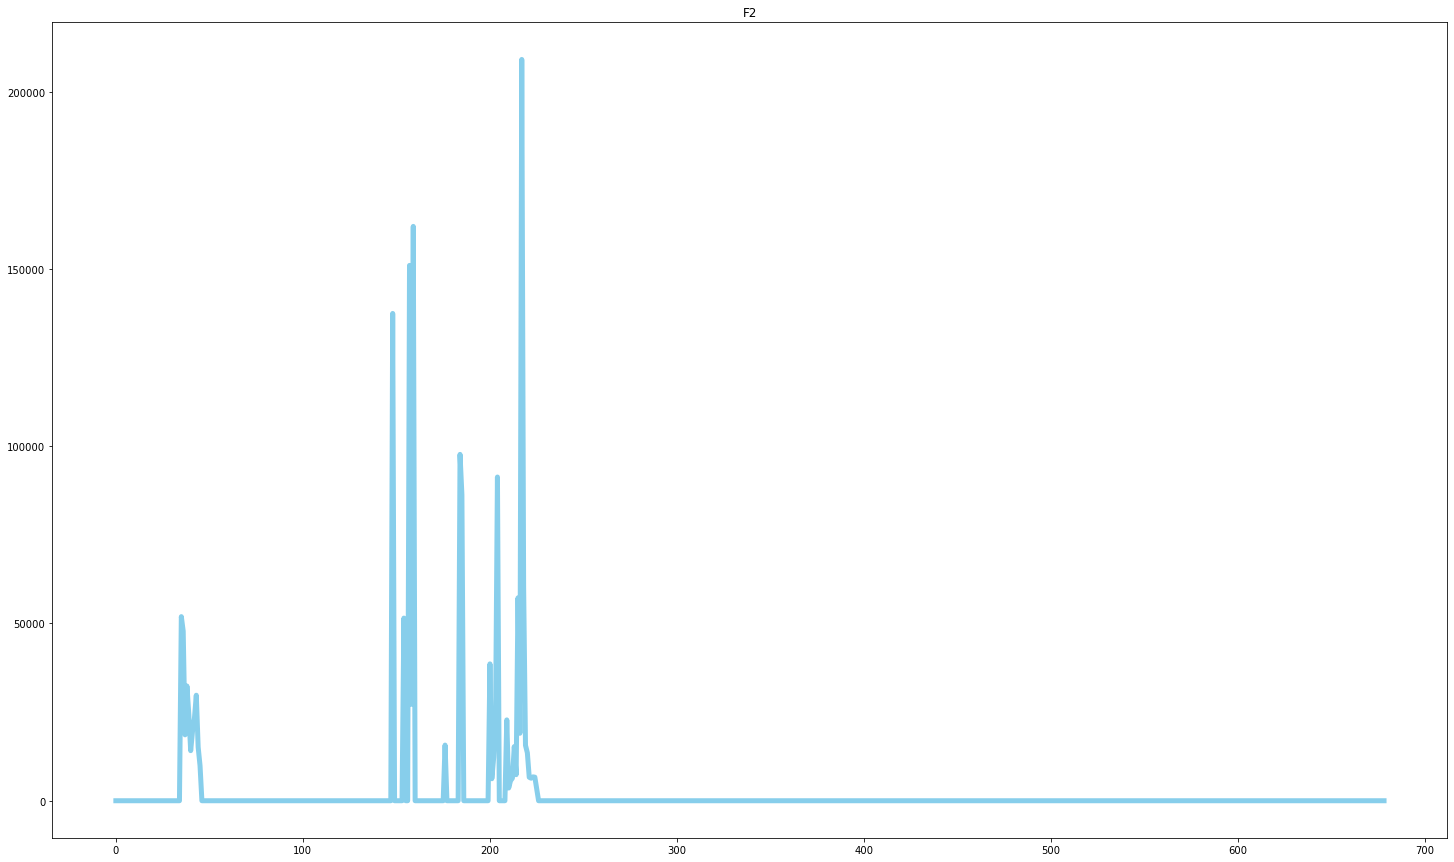

In [35]:
F2 = []
i = 0
n = len(F0)
while i < n:
    try:
        interval_max = max([F0[3*i], F0[3*i-1], F0[3*i+1]])
        if F0[i] < 4*interval_max:
            F2 += [0]
        else:
            F2 += [interval_max]
    except:
        F2 += [0]
    i += 1
    
plt.title('F2')        
plt.plot(F2, linewidth = 5, color = 'skyblue')      

### F3:

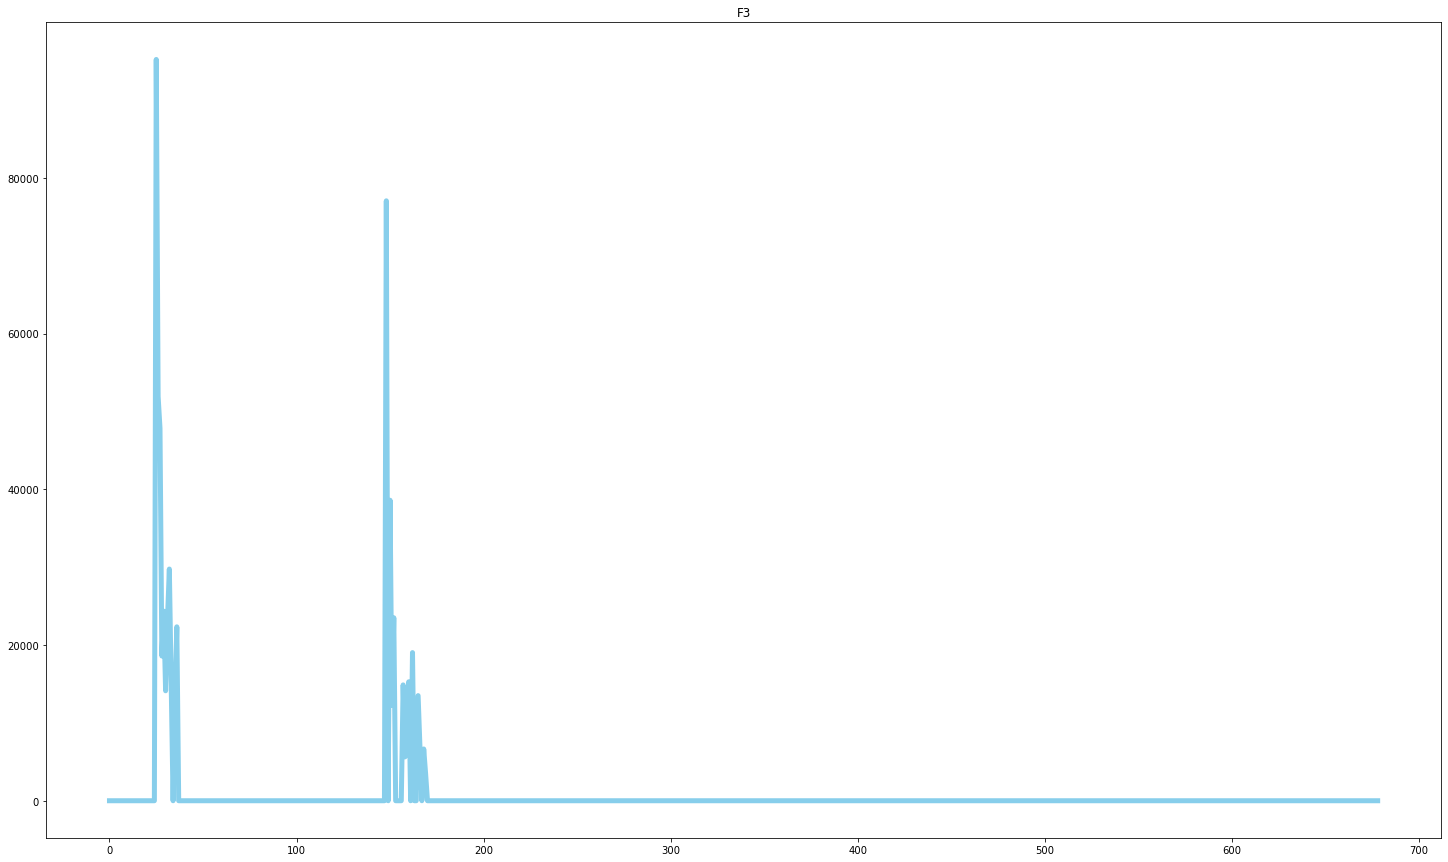

In [37]:
F3 = []
i = 0
n = len(F0)
while i < n:
    try:
        interval_max = max([F0[4 * i], F0[4 * i - 1], F0[4 * i + 1]])
        if F0[i] < 8 * interval_max:
            F3 += [0]
        else: 
            F3 += [interval_max]
    except:
        F3 += [0]
    i += 1
    
plt.title('F3')        
plt.plot(F3, linewidth = 5, color = 'skyblue')      

## Построение сонограммы по записи своего голоса

### Сонограма

Сонограма — это изображение кратковременного спектра сигнала (спектров на последовательности кадров) в координатах времени (горизонтальная ось), частоты (вертикальная ось) и энергии голоса (степень зачернения, цвет). Интенсивность темного (или цвета) отображает амплитуду спектра. Наиболее темные горизонтальные полосы частот показывают спектральные максимумы.

### Алгоритм построения сонограммы

1. Повторяем первые три шага алгоритма вычисления $F_{0}$.
2. Находим максимальное значение амплитудного спектра для F0 по всему сигналу — $A_{Max}$.
3. Интенсивность темного (или цвета) определяем относительно значения $A_{Max}$.
4. Интенсивность столбца значений амплитудного спектра выводим в интервале 50 − 4000 $H_{z}$.
5. Размерность столбца определяется пользователем.

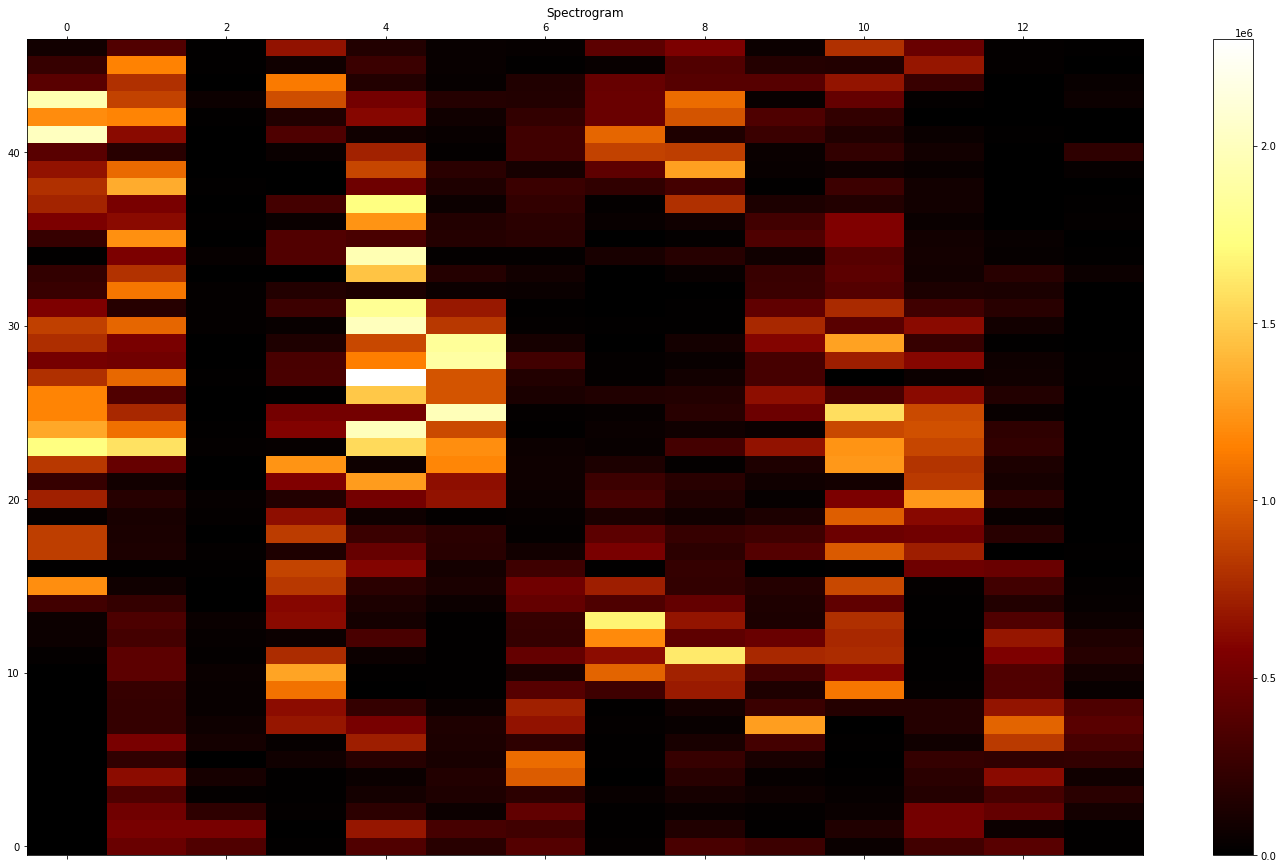

In [38]:
matrix_amp = []
for i in [amplitude_spectrum[k:k + Sr] for k in range(len(amplitude_spectrum) - 25)[::Sr]]:
    matrix_amp.append(i)

fig, ax = plt.subplots(nrows = 1, ncols = 1)
spectogram = ax.matshow(
    np.transpose(matrix_amp),
    interpolation = "nearest",
    aspect = "auto",
    cmap = plt.cm.afmhot,
    origin = "lower",
)
fig.colorbar(spectogram)
plt.title("Spectrogram")
plt.show()

## Выводы

В ходе выполнения лабораторной работы были изучены и практически применены дискретные преобразования Фурье c использованием библиотек Python для анализа речевых сигналов.